In [1]:
import earthaccess
import rioxarray
import rasterio
import xarray as xr
import numpy as np
from timebudget import timebudget

In [7]:
results = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    #temporal=("2020-01-01", "2021-12-31"),
    temporal=("2019-01-01", "2019-01-31"),
)


Granules found: 31


In [9]:
@timebudget
def via_earthaccess():
  files = earthaccess.open(results)
  ds = xr.open_mfdataset(files,
                         decode_times=False, 
                         parallel=True, 
                         data_vars=['analysed_sst', 'sea_ice_fraction'], 
                         concat_dim="time", 
                         combine="nested")
  return(ds)

ds2 = via_earthaccess()


Opening 31 granules, approx size: 11.63 GB


QUEUEING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/31 [00:00<?, ?it/s]

via_earthaccess took 67.904sec


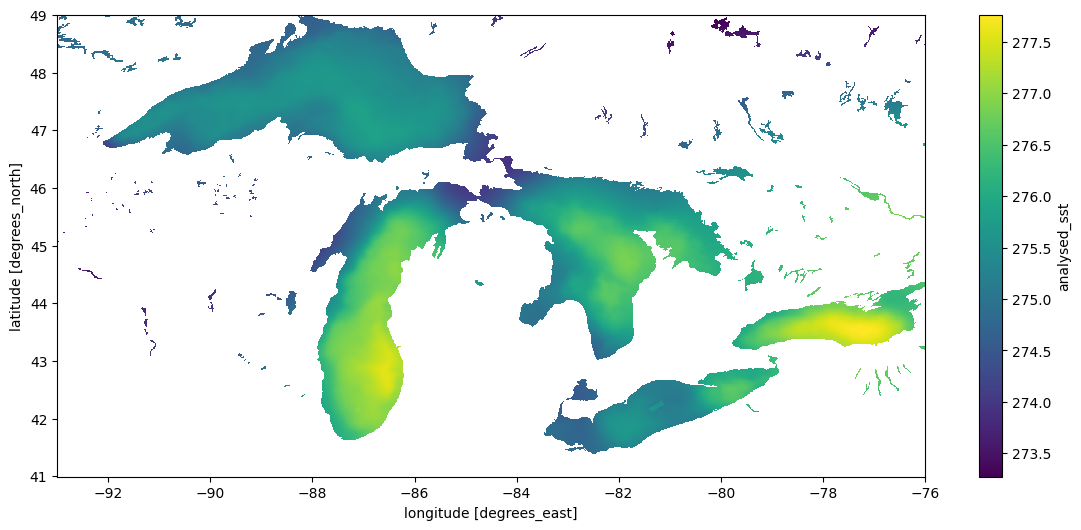

In [10]:

dds = ds2.sel(lon=slice(-93, -76), lat=slice(41, 49))
cond = (dds.sea_ice_fraction < 0.15) | np.isnan(dds.sea_ice_fraction)
result = dds.analysed_sst.where(cond)
result.mean("time").plot(figsize=(14, 6), x="lon", y="lat")

In [12]:

import os
from pathlib import Path
cookies = os.path.expanduser("~/.urs_cookies")
Path(cookies).touch()

@timebudget
def via_gdalvsi():
    ## pull out the URLs
    data_links = [granule.data_links(access="external") for granule in results]
    url_links = [f'{link[0]}' for link in data_links]
    # and here we go
    with rasterio.Env(GDAL_HTTP_COOKIEFILE=cookies, 
                    GDAL_HTTP_COOKIEJAR=cookies, 
                    GDAL_HTTP_NETRC=True):
        ds = xr.open_mfdataset(url_links, 
                               engine = "rasterio", 
                               decode_times=False,
                               parallel=True,
                               data_vars=['analysed_sst', 'sea_ice_fraction'], 
                               concat_dim="time", 
                               combine="nested")
    return(ds)

ds1 = via_gdalvsi()

via_gdalvsi took 73.710sec


In [41]:
url_links

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20190103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20190104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20190105090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20190106090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cum

In [56]:
dds = ds1.sel(x=slice(-93, -76), y=slice(41, 49)) # crs is messed up
dds = ds1.sel(x=slice(-93, -76)) # crs is messed up



In [ ]:
cond = (dds.sea_ice_fraction < 0.15) | np.isnan(dds.sea_ice_fraction)
result = dds.analysed_sst.where(cond)
result.std("time").plot(figsize=(14, 6), x="x", y="y")